# Initialize

## Imports, dependencies

In [1]:
import sys
COLAB = 'google.colab' in sys.modules

COLAB

True

In [2]:
if COLAB:
    %pip install segmentation_models
    %pip install tensorflow
    %pip install keras
    %pip install scikit-learn
    %pip install pygeoops
    %pip install dagshub mlflow
    %pip install pyquadkey2

In [3]:
import os
import random
import re
import shutil
from datetime import datetime

from tqdm import tqdm

import numpy as np

from IPython.display import Image, display, clear_output
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.python import keras
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.models import load_model
from keras.callbacks import ModelCheckpoint

os.environ['SM_FRAMEWORK'] = 'tf.keras'

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

import dagshub
import mlflow

from pyquadkey2 import quadkey
import cv2
from skimage import measure

import shapely
from shapely.geometry import LineString, Polygon, MultiPolygon

import pandas as pd
import geopandas as gpd
import pygeoops


Segmentation Models: using `tf.keras` framework.


## Helper methods

In [4]:
def show_images_side_by_side(images):
  cols = len(images)

  fig = figure()

  for i in range(cols):
    fig.add_subplot(1, cols, i+1)

    if len(images[i].shape) == 2 or (len(images[i].shape) == 3 and images[i].shape[2] == 1):
      imshow(images[i], cmap='Greys_r')
    else:
      imshow(images[i])

    axis('off')

In [5]:
def load_image(input_img_path, preprocess_input):
  img = load_img(input_img_path, target_size=(256,256))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  if preprocess_input:
    img_array = preprocess_input(img_array)

  return img_array

def load_images(input_img_paths, preprocess_input=None, max_dataset_len=None):
  if max_dataset_len:
    input_img_paths = input_img_paths[:max_dataset_len]

  return np.vstack([load_image(input_img_path, preprocess_input) for input_img_path in input_img_paths])

In [6]:
def load_target_mask(target_img_path):
  img = load_img(target_img_path, color_mode='grayscale', target_size=(256,256))
  img_array = img_to_array(img)
  img_array = img_array / 255
  return img_array

def load_target_masks(target_img_paths, max_dataset_len=None):
  if max_dataset_len:
    target_img_paths = target_img_paths[:max_dataset_len]

  return np.array([load_target_mask(target_img_path) for target_img_path in target_img_paths])

In [7]:
# Create a generator to yield images and masks in sync
def image_mask_generator(images, masks, batch_size, image_datagen, mask_datagen, seed=1):
    # Load images and masks
    image_generator = image_datagen.flow(
        images,
        batch_size=batch_size,
        seed=seed,
        shuffle=True
    )

    mask_generator = mask_datagen.flow(
        masks,
        batch_size=batch_size,
        seed=seed,
        shuffle=True
    )

    # Combine generators into one
    while True:
      x_batch = next(image_generator)
      y_batch = next(mask_generator)
      yield x_batch, y_batch

In [8]:
def create_model(base_model, backbone, pre_trained=True, encoder_freeze=False):
  if pre_trained:
    encoder_weights = 'imagenet'
  else:
    encoder_weights = None

  if base_model == 'unet':
    model = sm.Unet(backbone, encoder_weights=encoder_weights, encoder_freeze=encoder_freeze)
  elif base_model == 'fpn':
    model = sm.FPN(backbone, encoder_weights=encoder_weights, encoder_freeze=encoder_freeze)
  elif base_model == 'linknet':
    model = sm.Linknet(backbone, encoder_weights=encoder_weights, encoder_freeze=encoder_freeze)
  elif base_model == 'pspnet':
    model = sm.PSPNet(backbone, encoder_weights=encoder_weights, encoder_freeze=encoder_freeze)

  return model

In [9]:
def display_train_history(tr_acc, val_acc, tr_loss, val_loss,
                          figsize=(10,4)):
    i_best_acc = np.argmax(val_acc)
    best_i = np.argmin(val_loss)
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    ax.grid()
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc), label="train: {0:.2f}".format(100*tr_acc[-1]))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc), label="validation: {0:.2f}".format(100*val_acc[-1]))
    plt.plot(1+i_best_acc, 100*val_acc[i_best_acc], 'or', label="best: {0:.2f}".format(100*val_acc[i_best_acc]))
    plt.text(1+i_best_acc, 101*val_acc[i_best_acc], "{0:.2f}".format(100*val_acc[i_best_acc]))
    plt.title('IOU score (%)', fontsize=18)
    plt.ylabel('score (%)', fontsize=18)
    plt.xlabel('epoch: {}'.format(len(tr_acc)), fontsize=18)
    plt.legend(loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.grid()
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss), label="train: {0:.2f}".format(tr_loss[-1]))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss), label="validation: {0:.2f}".format(val_loss[-1]))
    plt.plot(1+best_i, val_loss[best_i], 'or', label="best: {0:.2f}".format(val_loss[best_i]))
    plt.title('loss', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('epoch', fontsize=18)
    plt.legend(loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [10]:
# Wrap loss and metric functions. This is necessary for model load,
# since the classes need to implement the get_config() and from_config() methods

@tf.keras.utils.register_keras_serializable(name="CustomJaccardLoss")
class CustomJaccardLoss(sm.losses.JaccardLoss):
    @classmethod
    def from_config(cls, config):
        if isinstance(config, dict):
            return cls(**config)
        else:
            return cls()

    def get_config(self):
        return {}

@tf.keras.utils.register_keras_serializable(name="CustomIOUScore")
class CustomIOUScore(sm.metrics.IOUScore):
    @classmethod
    def from_config(cls, config):
        if isinstance(config, dict):
            return cls(**config)
        else:
            return cls()

    def get_config(self):
        return {}

custom_objects={
    'CustomJaccardLoss': CustomJaccardLoss,
    'CustomIOUScore': CustomIOUScore
    }

# Prepare input data

In [11]:
import shutil

if COLAB:
  url = "'https://drive.usercontent.google.com/download?id=1--iKvkhO7M_dtXPaq1ptQUasDWnhd07b&export=download&confirm=t'"

  !wget $url -O ./data.zip

  shutil.unpack_archive('data.zip', 'data')

--2024-10-04 06:54:48--  https://drive.usercontent.google.com/download?id=1--iKvkhO7M_dtXPaq1ptQUasDWnhd07b&export=download&confirm=t
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.98.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127400217 (121M) [application/octet-stream]
Saving to: ‘./data.zip’

./data.zip          100%[===================>] 121.50M   252MB/s    in 0.5s    

2024-10-04 06:54:51 (252 MB/s) - ‘./data.zip’ saved [127400217/127400217]



In [12]:
input_dir = "data/img/"
target_dir = "data/raster/"

img_size = (256, 256)
num_classes = 1
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths), len(target_img_paths))

Number of samples: 9256 9256


In [13]:
x_train_paths, x_test_paths, y_train_paths, y_test_paths = train_test_split(input_img_paths, target_img_paths, test_size=0.2, random_state=0)
x_train_paths, x_val_paths, y_train_paths, y_val_paths = train_test_split(x_train_paths, y_train_paths, test_size=0.3, random_state=0)

## Explore data

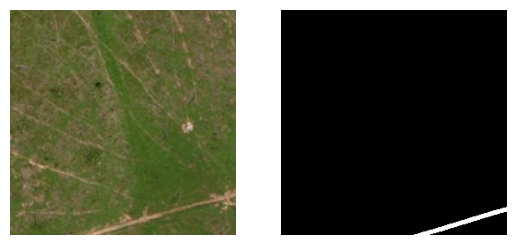

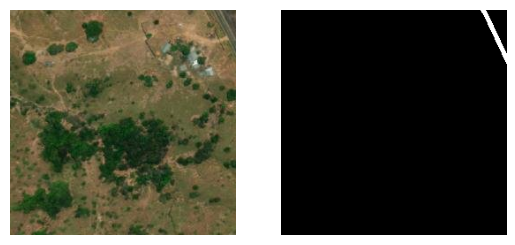

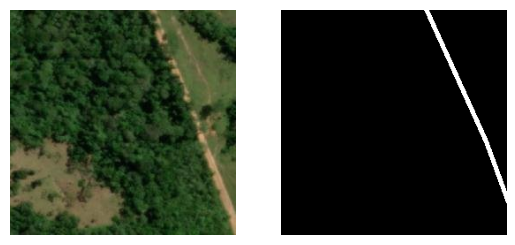

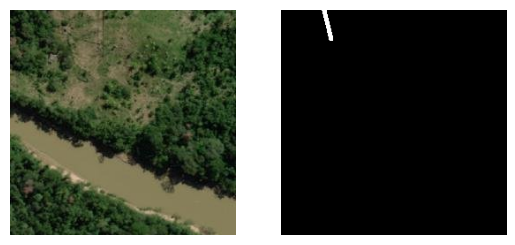

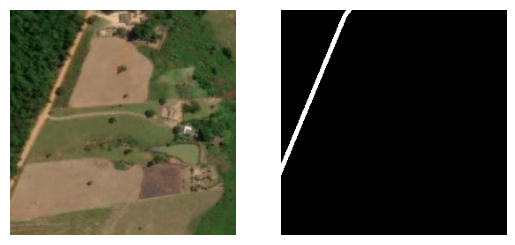

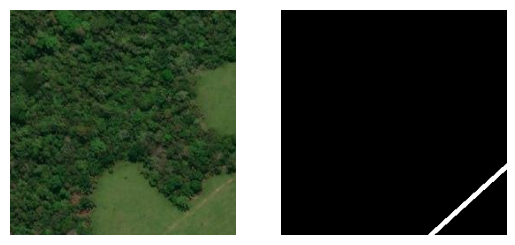

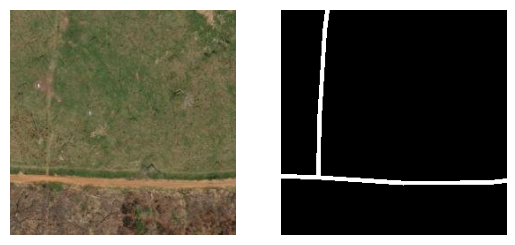

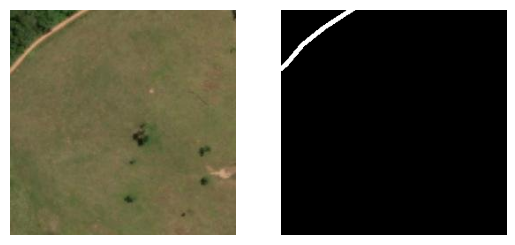

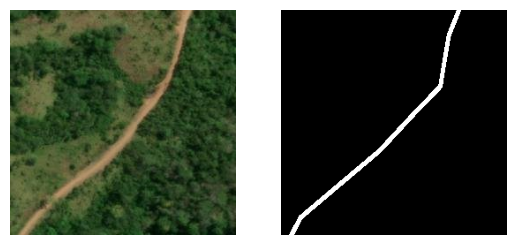

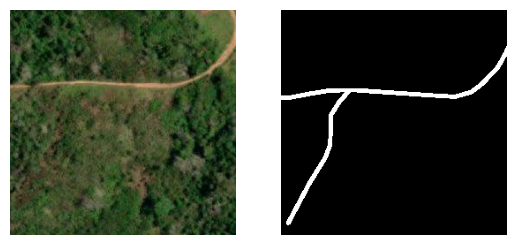

In [14]:
# Display satellite images and map rasterized data for some random map tiles

for i in random.sample(range(len(target_img_paths)), 10):
  show_images_side_by_side([imread(input_img_paths[i]), imread(target_img_paths[i])])

## Data augmentation

In [15]:
data_gen_args = dict(
    dtype='float32',
    shear_range=.2,
    zoom_range=0.05,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
)

In [16]:
sample_img_index = random.randint(0, len(x_train_paths))

sample_input_img = load_img(x_train_paths[sample_img_index], target_size=(256,256))
sample_input_img = img_to_array(sample_input_img)
sample_input_img = np.expand_dims(sample_input_img, axis=0)
sample_input_img = sample_input_img / 255

sample_target_img = load_img(y_train_paths[sample_img_index], target_size=(256,256))
sample_target_img = img_to_array(sample_target_img)
sample_target_img = np.expand_dims(sample_target_img, axis=0)
sample_target_img = sample_target_img / 255

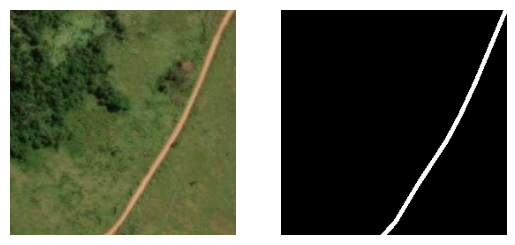

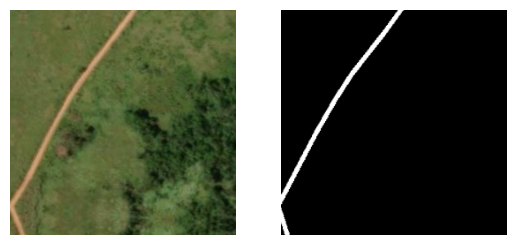

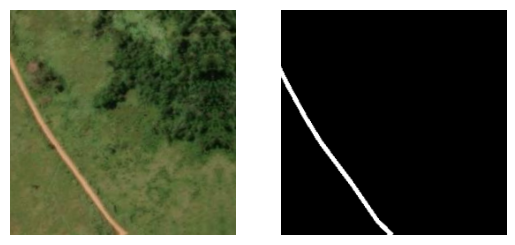

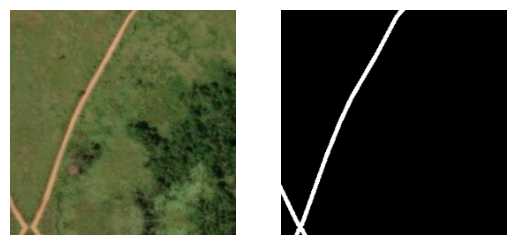

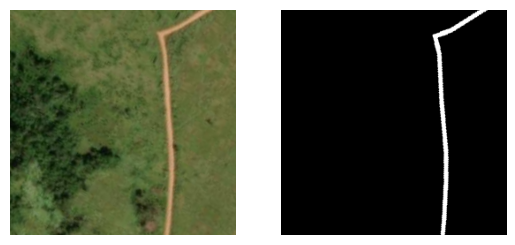

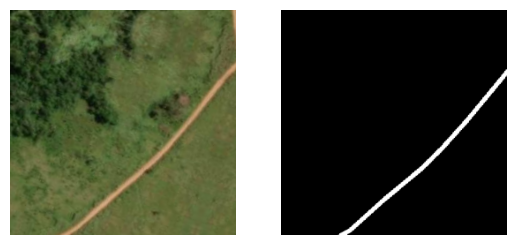

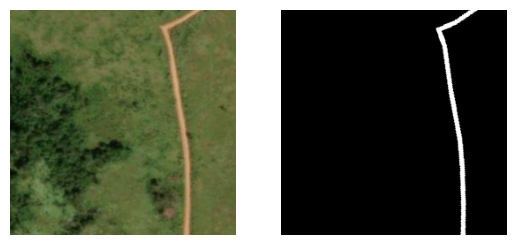

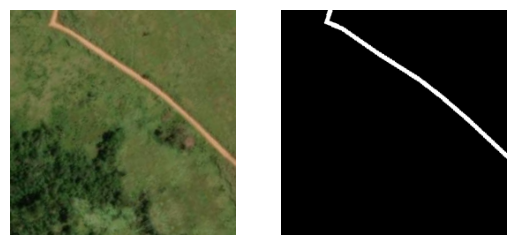

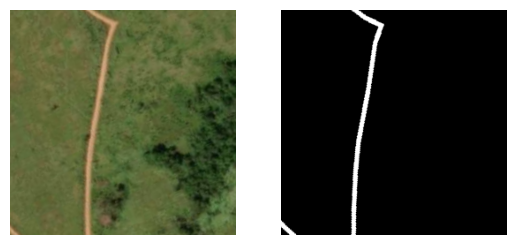

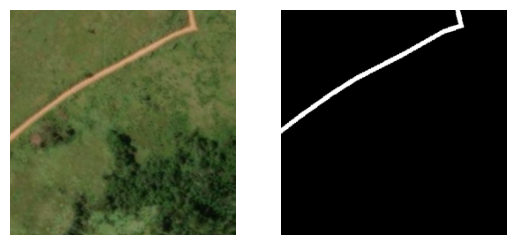

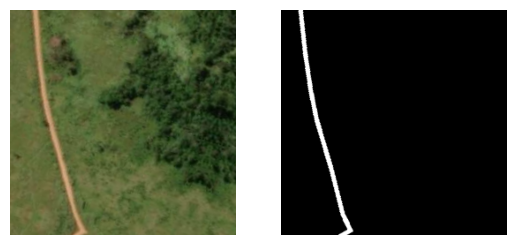

In [17]:
sample_input_generator = ImageDataGenerator(**data_gen_args).flow(sample_input_img, seed=1)
sample_target_generator = ImageDataGenerator(**data_gen_args).flow(sample_target_img, seed=1)

show_images_side_by_side([sample_input_img[0], sample_target_img[0]])

for i in range(10):
  show_images_side_by_side([next(sample_input_generator)[0], next(sample_target_generator)[0]])

# Model training

## Exploratory training

Prepare the data and analyze one specific model. Use this section to ensure correctness of the code or debug and inspect one specific model

In [18]:
base_model = 'unet'
backbone = 'resnet34'
pre_trained = True
encoder_freeze = False

In [19]:
preprocess_input = sm.get_preprocessing(backbone)

train_input_datagen_args = data_gen_args.copy()
train_input_datagen_args['preprocessing_function'] = preprocess_input

train_input_datagen = ImageDataGenerator(**train_input_datagen_args)
train_target_datagen = ImageDataGenerator(**data_gen_args)

In [20]:
x_train = load_images(x_train_paths)
y_train = load_target_masks(y_train_paths)
x_val = load_images(x_val_paths)
y_val = load_target_masks(y_val_paths)
x_test = load_images(x_test_paths)
y_test = load_target_masks(y_test_paths)

train_generator = image_mask_generator(
    images=x_train,
    masks=y_train,
    batch_size=batch_size,
    image_datagen=train_input_datagen,
    mask_datagen=train_target_datagen
)

In [21]:
modelpath = "best_model.keras"

checkpoint = ModelCheckpoint(modelpath, monitor='val_loss', verbose=1,
                             save_best_only=True,
                             mode='min')

serie_tr_iou = []
serie_val_iou = []
serie_tr_loss  = []
serie_val_loss = []

In [22]:
model = create_model(base_model, backbone, pre_trained, encoder_freeze)

model.compile(
    'Adam',
    loss=CustomJaccardLoss(),
    metrics=[CustomIOUScore()],
)


85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


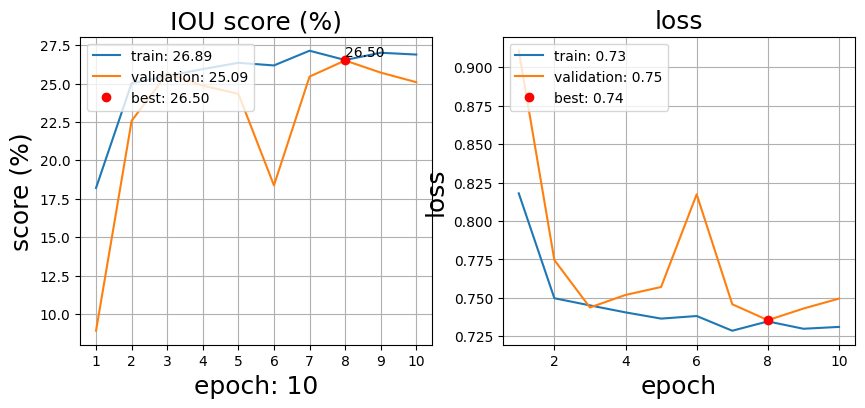

In [23]:
epochs = 10

for e in range(epochs):
    epoch_output = model.fit(
      train_generator,
      steps_per_epoch=len(x_train) // batch_size,
      epochs=1,
      callbacks=[checkpoint],
      validation_data=[x_val, y_val]
    )

    serie_tr_iou.append(epoch_output.history["iou_score"][0])
    serie_val_iou.append(epoch_output.history["val_iou_score"][0])
    serie_tr_loss.append(epoch_output.history["loss"][0])
    serie_val_loss.append(epoch_output.history["val_loss"][0])

    clear_output()
    display_train_history(serie_tr_iou, serie_val_iou,
                          serie_tr_loss, serie_val_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


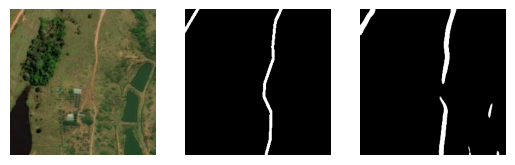

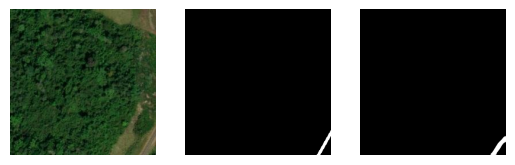

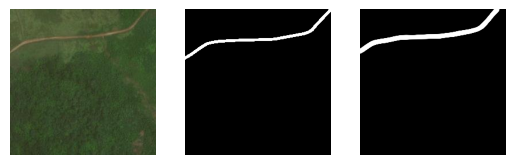

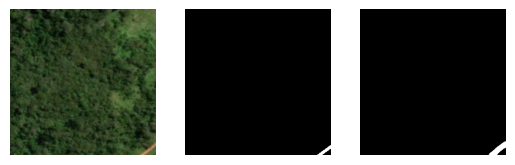

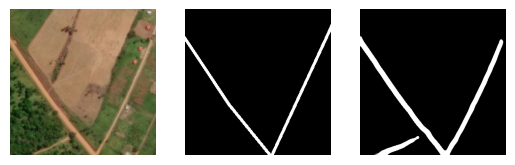

In [24]:
model = load_model(modelpath, custom_objects=custom_objects)

train_preds = model.predict(x_train[:100])

for i in random.sample(range(100), 5):
  show_images_side_by_side([imread(x_train_paths[i]), imread(y_train_paths[i]), train_preds[i]])

## Training with experiment tracking

In [18]:
dagshub.init(repo_owner='pbvaras', repo_name='mvp-mbit', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=9639b392-4895-40d4-9d7b-4615b5990c9e&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=15385c792ce60733720e753ecf052ae8be855ca259b1f8de152089a62863f1cc




Accessing as pbvaras

Initialized MLflow to track repo "pbvaras/mvp-mbit"

Repository pbvaras/mvp-mbit initialized!

In [19]:
base_model = 'linknet' # unet, fpn, linknet, pspnet
backbone = 'resnet34' # All backbones available at https://github.com/qubvel/segmentation_models?tab=readme-ov-file#models-and-backbones
pre_trained = True
encoder_freeze = True

In [20]:
preprocess_input = sm.get_preprocessing(backbone)

train_input_datagen_args = data_gen_args.copy()
train_input_datagen_args['preprocessing_function'] = preprocess_input

train_input_datagen = ImageDataGenerator(**train_input_datagen_args)
train_target_datagen = ImageDataGenerator(**data_gen_args)

x_train = load_images(x_train_paths)
y_train = load_target_masks(y_train_paths)
x_val = load_images(x_val_paths, preprocess_input)
y_val = load_target_masks(y_val_paths)
x_test = load_images(x_test_paths, preprocess_input)
y_test = load_target_masks(y_test_paths)

train_generator = image_mask_generator(
    images=x_train,
    masks=y_train,
    batch_size=batch_size,
    image_datagen=train_input_datagen,
    mask_datagen=train_target_datagen
)

In [21]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [22]:
epochs = 100

mlflow.autolog()

with mlflow.start_run() as run:

  model = create_model(base_model, backbone, pre_trained, encoder_freeze)

  model.compile(
    'Adam',
    loss=CustomJaccardLoss(),
    metrics=[CustomIOUScore()],
  )

  mlflow.log_param('base_model', base_model)
  mlflow.log_param('backbone', backbone)
  mlflow.log_param('pre_trained', pre_trained)
  mlflow.log_param('encoder_freeze', encoder_freeze)

  epoch_output = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=[x_val, y_val]
  )

  run_id = run.info.run_id


2024/10/04 06:55:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/10/04 06:55:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/10/04 06:55:37 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2024/10/04 06:55:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/04 06:55:40 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'generator'>. Dataset logging skipped.
2024/10/04 06:55:40 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'list'>. Dataset logging skipped.


Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 156s 627ms/step - iou_score: 0.0914 - loss: 0.9086 - val_iou_score: 0.0970 - val_loss: 0.9029
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 120s 545ms/step - iou_score: 0.2365 - loss: 0.7633 - val_iou_score: 0.2047 - val_loss: 0.7955
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 87s 541ms/step - iou_score: 0.2486 - loss: 0.7514 - val_iou_score: 0.2501 - val_loss: 0.7503
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 85s 531ms/step - iou_score: 0.2558 - loss: 0.7442 - val_iou_score: 0.2517 - val_loss: 0.7485
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 519ms/step - iou_score: 0.2612 - loss: 0.7387 - val_iou_score: 0.2514 - val_loss: 0.7490
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 517ms/step - iou_score: 0.2646 - loss: 0.7354 - val_iou_score: 0.2556 - val_loss: 0.7448
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 516ms/step - iou_score: 0.2634 - loss: 0.7366 - val_iou_score: 0.2511 - val_loss: 0.7493
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 517ms/step - io

2024/10/04 07:36:20 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpvk43qbkl/model, flavor: keras). Fall back to return ['keras==3.4.1']. Set logging level to DEBUG to see the full traceback. 
2024/10/04 07:36:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run dapper-wolf-340 at: https://dagshub.com/pbvaras/mvp-mbit.mlflow/#/experiments/0/runs/09b860f702734d0cb04daf3b0f596b11.
2024/10/04 07:36:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/pbvaras/mvp-mbit.mlflow/#/experiments/0.


# Explore results

## Generate predictions

In [23]:
dagshub.init(repo_owner='pbvaras', repo_name='mvp-mbit', mlflow=True)

Initialized MLflow to track repo "pbvaras/mvp-mbit"

Repository pbvaras/mvp-mbit initialized!

In [24]:
# Load the last trained model. If not set, load the model with the best iou_score in validation
if 'run_id' not in locals():
  run_id = mlflow.search_runs(order_by=["metrics.val_iou_score DESC"]).iloc[0]['run_id']

model = mlflow.keras.load_model("runs:/" + run_id + "/model")

In [25]:
train_preds = model.predict(x_train)
val_preds = model.predict(x_val)
test_preds = model.predict(x_test)

162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step


## Visualize predictions

idx: 83 data/img/tile_17_69601_40484.jpg


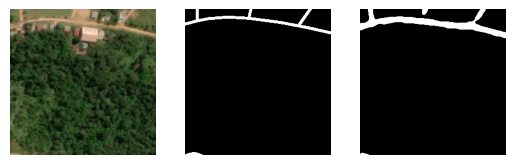

idx: 1458 data/img/tile_17_69620_40516.jpg


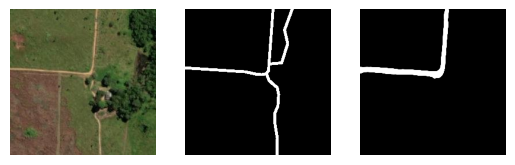

idx: 4601 data/img/tile_17_69580_40440.jpg


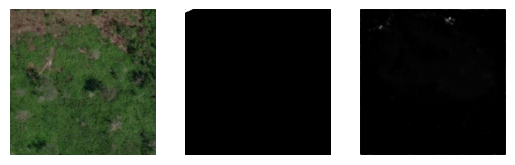

idx: 893 data/img/tile_17_69537_40397.jpg


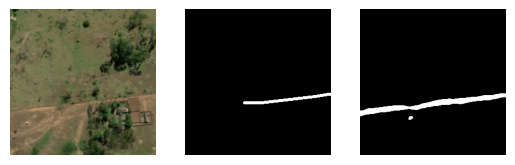

idx: 3130 data/img/tile_17_69572_40513.jpg


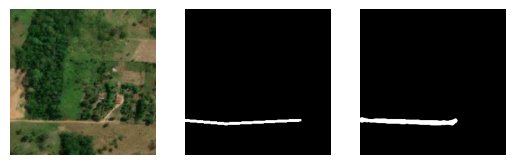

idx: 3899 data/img/tile_17_69615_40279.jpg


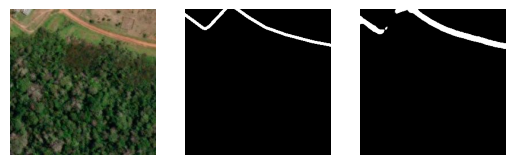

idx: 1312 data/img/tile_17_69574_40508.jpg


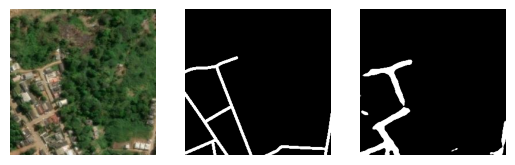

idx: 3368 data/img/tile_17_69702_40250.jpg


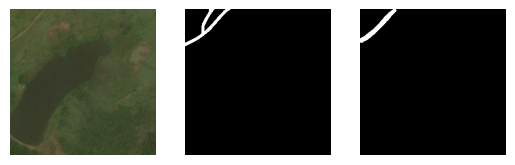

idx: 3799 data/img/tile_17_69532_40503.jpg


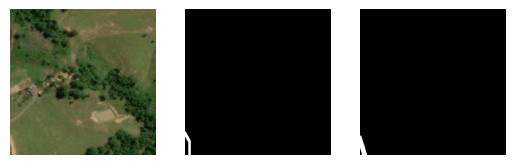

idx: 3874 data/img/tile_17_69551_40415.jpg


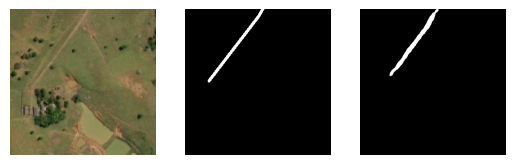

In [26]:
for i in random.sample(range(len(x_train)), 10):
  print('idx:', i, x_train_paths[i])
  show_images_side_by_side([imread(x_train_paths[i]), imread(y_train_paths[i]), train_preds[i]])
  plt.show()

In [27]:
for i in random.sample(range(len(x_val)), 50):
  print('idx:', i, x_val_paths[i])
  show_images_side_by_side([imread(x_val_paths[i]), imread(y_val_paths[i]), val_preds[i]])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [28]:
for i in random.sample(range(len(x_test)), 50):
  print('idx:', i, x_test_paths[i])
  show_images_side_by_side([imread(x_test_paths[i]), imread(y_test_paths[i]), test_preds[i]])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Reconstruct road geometry

In [61]:
def predictions_to_geojson_files(predictions, input_files, geojson_path):
  zoom_level = 17
  pattern = r'_(\d+)_(\d+)\.'

  os.makedirs(geojson_path, exist_ok=True)

  all_gdfs = []

  for idx in tqdm(range(len(predictions))):
    match = re.search(pattern, input_files[idx])
    tile = (int(match.group(1)), int(match.group(2)))

    tile_min_lat, tile_min_lon = quadkey.from_tile((tile[1], tile[0]), zoom_level).to_geo(anchor=quadkey.TileAnchor.ANCHOR_SW)
    tile_max_lat, tile_max_lon = quadkey.from_tile((tile[1], tile[0]), zoom_level).to_geo(anchor=quadkey.TileAnchor.ANCHOR_NE)

    binary_mask = (predictions[idx] > 0.5).astype(np.uint8)

    # Find contours using OpenCV. RETR_CCOMP retrieves external and internal contours (holes)
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
      continue

    lines = []

    contour_polygons = []
    for contour_polygon in contours:
      contour_polygons.append(contour_polygon[:, 0, :])

    child_contours_dict = {}

    # Reconstruct contour hierarchy from findContours results. Parents represent
    # external contours, children are the internal contours (holes in the external hull)
    # See hierarchy description for details
    # https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a
    for i, contour_hierarchy in enumerate(hierarchy[0]):
      parent = contour_hierarchy[3]
      if parent != -1:
        if parent in child_contours_dict:
          child_contours_dict[parent].append(i)
        else:
          child_contours_dict[parent] = [i]

    polygons = []

    # Create polygons or multi-polygons for contours
    for i, contour_hierarchy in enumerate(hierarchy[0]):
      if contour_hierarchy[3] != -1: # This is a child contour
        continue

      contour_polygon = contour_polygons[i]

      if len(contour_polygon) < 4:
        continue

      if i in child_contours_dict:
        child_contour_polygons = [contour_polygons[child_idx] for child_idx in child_contours_dict[i]]

        # If the contour has holes, create a multi-polygon object
        # The first element in the tuple represents the external contour
        # The second element contains all internal contours (holes)
        multi_polygon = MultiPolygon([ (contour_polygon, child_contour_polygons) ])
        polygons.append(multi_polygon)

      else:
        polygons.append(Polygon(contour_polygon))

    # Convert the contours to lines by extracting their centerline
    for polygon in polygons:
      try:
        centerline = pygeoops.centerline(polygon)
        lines.append(centerline)
      except Exception as e:
        print('Failed to find centerline for polygon:', polygon)
        print(e)

    # Convert to geo-referenced coordinates
    geo_lines = []

    height, width = (256, 256)

    for line in lines:
      geo_line = shapely.transform(line, lambda x: ([tile_min_lon, tile_max_lat] + x / [width, height] * [tile_max_lon - tile_min_lon, tile_min_lat - tile_max_lat]))
      geo_lines.append(geo_line)

    gdf = gpd.GeoDataFrame(geometry=geo_lines, crs='EPSG:4326')

    all_gdfs.append(gdf)

    geojson_filename = f'roads_{tile[0]}_{tile[1]}.json'

    gdf.to_file(f'{geojson_path}/{geojson_filename}', driver='GeoJSON')

  gpd.GeoDataFrame(pd.concat(all_gdfs)).to_file(f'{geojson_path}.json', driver='GeoJSON')

In [62]:
geojson_path = 'out/geojson'

predictions_to_geojson_files(train_preds, x_train_paths, geojson_path + '/train')
predictions_to_geojson_files(val_preds, x_val_paths, geojson_path + '/val')
predictions_to_geojson_files(test_preds, x_test_paths, geojson_path + '/test')

 36%|███▋      | 1880/5182 [00:56<01:25, 38.76it/s]

Failed to find centerline for polygon: MULTIPOLYGON (((226 0, 225 1, 225 6, 223 8, 223 9, 218 14, 218 15, 215 18, 215 19, 214 20, 214 21, 213 22, 213 23, 212 24, 212 25, 211 26, 211 27, 210 28, 210 29, 209 30, 209 31, 208 32, 208 33, 207 34, 207 35, 206 36, 206 37, 205 38, 205 39, 204 40, 204 41, 200 45, 200 46, 198 48, 198 49, 197 50, 197 51, 196 52, 196 53, 193 56, 193 57, 191 59, 190 59, 186 63, 186 64, 185 65, 185 67, 184 68, 184 69, 183 70, 183 71, 180 74, 180 75, 179 76, 179 77, 178 78, 178 79, 174 83, 174 84, 171 87, 171 88, 169 90, 169 91, 166 94, 166 95, 165 96, 165 97, 162 100, 162 101, 161 102, 161 103, 159 105, 158 105, 157 106, 154 106, 153 105, 152 105, 149 102, 148 102, 147 101, 146 101, 144 99, 143 99, 142 98, 141 98, 140 97, 139 97, 137 95, 137 94, 136 94, 135 93, 132 93, 131 92, 130 92, 128 90, 128 89, 127 88, 126 88, 123 85, 122 85, 120 83, 119 83, 116 80, 116 75, 117 74, 117 73, 118 72, 118 71, 119 70, 119 69, 122 66, 122 65, 124 63, 124 62, 129 57, 129 56, 130 55, 

 40%|███▉      | 2048/5182 [01:01<01:07, 46.52it/s]

Failed to find centerline for polygon: MULTIPOLYGON (((247 63, 246 64, 246 65, 243 68, 241 68, 239 66, 238 66, 237 67, 237 68, 234 71, 232 71, 230 73, 229 73, 224 78, 224 79, 222 81, 222 82, 221 83, 221 84, 217 88, 217 89, 216 90, 216 91, 215 92, 215 93, 214 94, 214 95, 220 95, 221 96, 221 98, 220 99, 219 99, 216 102, 215 102, 214 103, 212 103, 209 106, 208 106, 208 107, 205 110, 204 110, 202 112, 202 113, 199 116, 197 116, 190 123, 190 124, 187 127, 187 128, 186 129, 186 130, 184 132, 184 135, 187 135, 187 134, 188 133, 188 132, 189 131, 191 131, 192 132, 192 133, 191 134, 191 135, 190 136, 190 137, 189 138, 189 139, 185 143, 185 145, 184 146, 184 151, 183 152, 183 153, 182 154, 182 156, 178 160, 178 161, 177 162, 176 162, 176 163, 173 166, 173 167, 169 171, 168 171, 167 172, 167 173, 166 174, 166 175, 165 176, 165 177, 164 178, 164 179, 162 181, 162 182, 154 190, 154 191, 147 198, 147 199, 146 200, 146 201, 145 202, 145 203, 144 204, 144 206, 143 207, 143 208, 139 212, 139 213, 137 2

 67%|██████▋   | 3460/5182 [01:43<00:46, 37.01it/s]

Failed to find centerline for polygon: POLYGON ((184 253, 188 253, 189 254, 188 253, 184 253))
IllegalArgumentException: Tolerance must be positive


 78%|███████▊  | 4026/5182 [02:00<00:35, 32.15it/s]

Failed to find centerline for polygon: MULTIPOLYGON (((93 0, 93 3, 94 4, 94 5, 93 6, 93 7, 91 9, 91 10, 89 12, 89 26, 88 27, 88 30, 87 31, 87 38, 86 39, 86 45, 85 46, 85 48, 84 49, 84 51, 83 52, 83 54, 82 55, 82 56, 81 57, 78 57, 76 59, 76 60, 75 61, 75 65, 74 66, 74 74, 73 75, 73 78, 72 79, 72 82, 71 83, 71 84, 70 85, 70 87, 69 88, 69 89, 68 90, 68 91, 67 92, 67 94, 66 95, 66 110, 65 111, 65 113, 64 114, 64 116, 62 118, 62 119, 61 120, 61 122, 60 123, 60 124, 59 125, 59 127, 58 128, 58 137, 57 138, 57 142, 56 143, 56 147, 55 148, 55 150, 54 151, 54 155, 53 156, 53 161, 52 162, 52 165, 51 166, 51 167, 50 168, 50 172, 49 173, 49 174, 48 175, 48 176, 47 177, 47 178, 44 181, 44 187, 43 188, 43 189, 42 190, 42 191, 39 194, 38 194, 38 195, 29 204, 29 205, 18 216, 18 217, 14 221, 14 222, 11 225, 10 225, 10 226, 6 230, 6 231, 4 233, 4 234, 2 236, 2 238, 0 240, 0 255, 3 255, 3 253, 4 252, 4 248, 5 247, 5 245, 6 244, 6 242, 7 241, 7 240, 9 238, 9 237, 10 236, 10 235, 11 234, 11 233, 13 231, 13 

 91%|█████████ | 4717/5182 [02:19<00:14, 31.15it/s]

Failed to find centerline for polygon: POLYGON ((22 63, 21 64, 21 65, 21 64, 22 63))
IllegalArgumentException: Tolerance must be positive


 91%|█████████▏| 4730/5182 [02:19<00:11, 40.96it/s]

Failed to find centerline for polygon: POLYGON ((74 55, 73 56, 73 57, 72 58, 72 59, 72 58, 73 57, 73 56, 74 55))
IllegalArgumentException: Tolerance must be positive


 38%|███▊      | 840/2222 [00:24<00:39, 35.32it/s]

Failed to find centerline for polygon: MULTIPOLYGON (((112 0, 112 1, 111 2, 110 2, 108 4, 107 4, 106 5, 105 5, 104 6, 102 6, 101 7, 100 7, 99 8, 98 8, 96 10, 93 10, 92 11, 91 11, 89 13, 88 13, 87 14, 86 14, 85 15, 84 15, 83 16, 82 16, 80 18, 78 18, 76 20, 75 20, 74 21, 73 21, 72 22, 70 22, 69 23, 68 23, 67 24, 66 24, 65 25, 62 25, 61 26, 59 26, 58 27, 56 27, 55 28, 54 28, 53 29, 52 29, 51 30, 47 30, 46 31, 45 31, 44 32, 43 32, 42 33, 41 33, 40 34, 38 34, 37 35, 36 35, 35 36, 34 36, 33 37, 31 37, 30 38, 28 38, 27 39, 26 39, 25 40, 24 40, 23 41, 21 41, 20 42, 18 42, 17 43, 14 43, 13 44, 11 44, 10 45, 9 45, 7 47, 0 47, 0 58, 3 58, 4 57, 5 57, 6 56, 11 56, 11 52, 12 51, 13 51, 14 52, 16 52, 17 53, 19 53, 20 52, 18 52, 16 50, 18 48, 19 48, 20 49, 23 49, 24 48, 30 48, 31 47, 32 47, 34 45, 35 45, 36 44, 37 44, 38 43, 39 43, 40 42, 42 42, 43 41, 48 41, 49 40, 50 40, 51 39, 52 39, 53 38, 54 38, 55 37, 58 37, 59 36, 61 36, 62 35, 63 35, 64 34, 65 34, 66 33, 67 33, 68 32, 69 32, 70 31, 71 31, 72 

 44%|████▎     | 969/2222 [00:29<00:41, 30.23it/s]

Failed to find centerline for polygon: MULTIPOLYGON (((117 5, 117 6, 114 9, 112 9, 111 10, 110 10, 107 13, 107 14, 106 15, 106 16, 105 17, 105 18, 102 21, 101 21, 100 22, 99 22, 99 23, 97 25, 97 26, 96 27, 96 28, 93 31, 93 32, 92 33, 92 34, 91 35, 91 40, 90 41, 90 42, 83 49, 83 53, 82 54, 82 55, 83 56, 83 59, 86 62, 86 63, 87 64, 87 65, 88 66, 88 67, 91 70, 91 71, 92 72, 92 73, 91 74, 91 76, 90 77, 90 78, 89 79, 89 80, 85 84, 84 84, 83 85, 82 85, 81 86, 80 86, 79 87, 79 88, 78 89, 78 90, 77 91, 77 92, 76 93, 76 96, 75 97, 75 98, 74 99, 74 101, 72 103, 72 104, 70 106, 70 114, 69 115, 69 118, 68 119, 68 121, 67 122, 67 123, 66 124, 66 127, 65 128, 65 129, 64 130, 64 131, 63 132, 63 133, 62 134, 62 136, 61 137, 61 138, 59 140, 59 141, 58 142, 58 144, 57 145, 57 147, 56 148, 56 149, 54 151, 54 154, 53 155, 53 161, 52 162, 52 163, 51 164, 51 166, 50 167, 50 169, 49 170, 49 171, 42 178, 42 179, 41 180, 41 181, 40 182, 40 183, 39 184, 39 186, 37 188, 37 189, 31 195, 31 200, 30 201, 30 203, 29

 64%|██████▍   | 1420/2222 [00:41<00:24, 33.41it/s]

Failed to find centerline for polygon: POLYGON ((156 31, 157 31, 158 32, 157 31, 156 31))
IllegalArgumentException: Tolerance must be positive


 82%|████████▏ | 1814/2222 [00:53<00:11, 36.82it/s]

Failed to find centerline for polygon: MULTIPOLYGON (((24 0, 24 1, 22 3, 22 4, 16 10, 15 10, 14 11, 14 12, 11 15, 10 15, 8 17, 7 16, 2 16, 1 17, 0 17, 0 43, 1 44, 3 44, 4 43, 4 42, 5 41, 5 40, 6 39, 6 36, 7 35, 8 35, 9 34, 16 34, 17 35, 19 35, 20 36, 22 36, 23 37, 27 37, 28 38, 36 38, 37 39, 38 39, 39 40, 39 41, 42 44, 42 49, 41 50, 41 61, 42 62, 42 74, 41 75, 41 77, 40 78, 40 81, 41 82, 41 90, 40 91, 40 98, 39 99, 39 101, 40 102, 40 104, 41 105, 41 107, 40 108, 40 110, 39 111, 39 112, 35 116, 28 116, 27 115, 24 115, 23 114, 19 114, 18 113, 15 113, 14 112, 8 112, 7 111, 1 111, 0 110, 0 121, 1 120, 2 120, 3 119, 10 119, 11 120, 16 120, 17 121, 19 121, 20 122, 22 122, 23 123, 30 123, 31 122, 34 122, 35 123, 36 123, 38 125, 38 126, 39 127, 39 134, 38 135, 38 143, 37 144, 37 146, 38 147, 38 158, 37 159, 37 174, 38 175, 38 194, 39 195, 39 197, 40 198, 41 198, 43 200, 43 202, 42 203, 42 204, 41 205, 41 206, 38 209, 35 209, 34 210, 32 210, 31 211, 29 211, 28 210, 25 210, 24 209, 20 209, 19 20

100%|██████████| 2222/2222 [01:04<00:00, 34.41it/s]


Failed to find centerline for polygon: MULTIPOLYGON (((241 0, 241 2, 240 3, 240 5, 239 6, 239 22, 240 23, 240 35, 241 36, 241 49, 240 50, 240 52, 239 53, 239 55, 238 56, 238 57, 235 60, 233 60, 232 61, 226 61, 223 64, 214 64, 213 63, 212 63, 211 62, 210 62, 209 63, 207 63, 206 64, 179 64, 178 63, 173 63, 172 64, 167 64, 166 63, 160 63, 159 62, 157 62, 155 60, 149 60, 148 61, 145 61, 144 62, 143 61, 135 61, 134 62, 130 62, 129 61, 120 61, 119 60, 118 60, 117 61, 108 61, 107 60, 103 60, 102 61, 98 61, 97 62, 96 62, 95 61, 92 61, 91 60, 85 60, 83 58, 83 56, 82 55, 82 54, 81 53, 81 46, 80 45, 80 44, 79 43, 79 37, 78 36, 78 35, 76 33, 75 33, 73 31, 72 31, 71 32, 71 35, 72 36, 72 39, 73 40, 73 42, 74 43, 74 45, 75 46, 75 49, 76 50, 76 52, 78 54, 78 56, 76 58, 73 58, 72 59, 66 59, 65 58, 48 58, 47 57, 40 57, 39 56, 16 56, 15 55, 12 55, 11 56, 4 56, 3 55, 0 55, 0 64, 1 64, 2 65, 3 65, 4 64, 7 64, 8 65, 15 65, 16 64, 19 64, 20 63, 22 63, 23 62, 24 62, 25 63, 27 63, 31 67, 31 71, 30 72, 30 73, 2

 19%|█▉        | 361/1852 [00:10<00:43, 34.24it/s]

Failed to find centerline for polygon: MULTIPOLYGON (((88 0, 88 1, 87 2, 87 3, 84 6, 84 7, 82 9, 81 9, 80 10, 74 10, 73 9, 69 9, 68 8, 62 8, 61 7, 58 7, 57 6, 44 6, 43 5, 40 5, 39 4, 2 4, 1 3, 0 3, 0 14, 2 14, 3 13, 26 13, 27 14, 45 14, 46 15, 55 15, 56 16, 62 16, 63 17, 73 17, 74 18, 76 18, 79 21, 79 25, 78 26, 78 35, 77 36, 77 41, 76 42, 76 45, 75 46, 75 49, 74 50, 74 57, 73 58, 73 62, 72 63, 72 68, 71 69, 71 79, 70 80, 70 82, 68 84, 66 84, 65 85, 55 85, 54 84, 43 84, 42 83, 32 83, 31 82, 14 82, 13 81, 11 81, 10 82, 0 82, 0 91, 4 91, 6 93, 6 99, 5 100, 5 102, 4 103, 4 105, 3 106, 3 108, 2 109, 2 111, 0 113, 0 119, 1 120, 0 121, 0 187, 2 187, 4 185, 5 185, 6 184, 12 184, 13 183, 20 183, 24 187, 25 187, 26 188, 30 188, 31 187, 36 187, 37 188, 42 188, 43 187, 44 187, 46 185, 50 185, 51 186, 53 186, 54 185, 61 185, 63 187, 65 187, 66 188, 69 188, 70 187, 72 187, 73 186, 74 186, 75 185, 80 185, 81 186, 82 186, 83 185, 85 185, 86 184, 91 184, 92 185, 93 185, 94 186, 94 187, 95 188, 95 191,

 39%|███▉      | 719/1852 [00:21<00:24, 46.71it/s]

Failed to find centerline for polygon: POLYGON ((98 2, 97 3, 98 2, 99 2, 98 2))
IllegalArgumentException: Tolerance must be positive


 56%|█████▌    | 1031/1852 [00:30<00:26, 30.79it/s]

Failed to find centerline for polygon: POLYGON ((200 139, 199 140, 197 140, 199 140, 200 139))
IllegalArgumentException: Tolerance must be positive


 68%|██████▊   | 1253/1852 [00:37<00:18, 31.79it/s]

Failed to find centerline for polygon: MULTIPOLYGON (((12 0, 12 1, 11 2, 13 4, 15 4, 18 7, 18 9, 19 10, 20 10, 23 13, 23 14, 24 15, 24 16, 25 17, 26 17, 28 19, 28 20, 31 23, 31 24, 32 25, 33 25, 38 30, 38 31, 39 32, 40 32, 43 35, 43 37, 44 38, 44 39, 51 46, 51 47, 52 48, 52 49, 56 53, 56 54, 58 56, 58 57, 61 60, 61 61, 62 62, 62 65, 68 65, 69 66, 74 66, 76 68, 76 69, 78 71, 78 72, 91 85, 92 85, 97 90, 97 91, 98 92, 98 95, 99 96, 99 97, 102 100, 102 101, 103 102, 103 103, 104 104, 106 104, 107 105, 108 105, 112 109, 112 111, 113 112, 114 112, 116 114, 116 115, 117 116, 117 119, 116 120, 116 124, 115 125, 113 125, 112 124, 110 124, 109 123, 108 123, 107 122, 107 124, 110 127, 110 128, 111 128, 112 129, 113 129, 115 131, 116 131, 123 138, 123 141, 122 142, 122 144, 124 146, 124 147, 128 151, 129 151, 133 155, 133 156, 134 157, 134 158, 132 160, 129 160, 128 159, 127 159, 125 161, 124 161, 123 162, 116 162, 116 165, 119 165, 120 166, 121 166, 123 168, 123 169, 128 174, 129 174, 130 175, 13

 81%|████████  | 1502/1852 [00:44<00:10, 32.65it/s]

Failed to find centerline for polygon: POLYGON ((16 51, 15 52, 16 51, 17 51, 16 51))
IllegalArgumentException: Tolerance must be positive


100%|██████████| 1852/1852 [00:54<00:00, 33.77it/s]


# Save predictions

In [63]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
train_preds[0].shape

(256, 256, 1)

In [67]:
# Save predictions as images
raster_path = 'out/raster'

os.makedirs(f'{raster_path}/train/', exist_ok=True)
os.makedirs(f'{raster_path}/val/', exist_ok=True)
os.makedirs(f'{raster_path}/test/', exist_ok=True)

for i in tqdm(range(len(train_preds))):
  zoom_level = 17
  pattern = r'_(\d+)_(\d+)\.'

  match = re.search(pattern, x_train_paths[i])
  tile = (int(match.group(1)), int(match.group(2)))

  Image.fromarray(np.squeeze((train_preds[i] > 0.5).astype(np.uint8))*255).save(f'{raster_path}/train/raster_{tile[0]}_{tile[1]}.png')

for i in tqdm(range(len(val_preds))):
  zoom_level = 17
  pattern = r'_(\d+)_(\d+)\.'

  match = re.search(pattern, x_val_paths[i])
  tile = (int(match.group(1)), int(match.group(2)))

  Image.fromarray(np.squeeze((val_preds[i] > 0.5).astype(np.uint8))*255).save(f'{raster_path}/val/raster_{tile[0]}_{tile[1]}.png')

for i in tqdm(range(len(test_preds))):
  zoom_level = 17
  pattern = r'_(\d+)_(\d+)\.'

  match = re.search(pattern, x_test_paths[i])
  tile = (int(match.group(1)), int(match.group(2)))

  Image.fromarray(np.squeeze((test_preds[i] > 0.5).astype(np.uint8))*255).save(f'{raster_path}/test/raster_{tile[0]}_{tile[1]}.png')


100%|██████████| 1852/1852 [00:01<00:00, 971.46it/s]


In [68]:
import shutil
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

if COLAB:
    archive_path = f'/content/drive/MyDrive/MBIT/Proyecto/predictions_{timestamp}'
else:
    archive_path = f'predictions_{timestamp}'

shutil.make_archive(archive_path, 'zip', 'out')

'/content/drive/MyDrive/MBIT/Proyecto/predictions_20241004_095108.zip'